In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy.optimize import least_squares

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
f1=lambda x:1-np.sum(np.pi*x,axis=-1)**2/2#+np.sum(np.pi*x,axis=-1)**4/24
f2=lambda x:np.cos(np.pi*np.sum(x,axis=-1))
def get_data(k,scale,seed=0):
    np.random.seed(seed)
    X=scale*(np.random.rand(k,1)-1.0/2)
    Y=np.where(np.sum(X,axis=-1)>0,f1(X),f2(X))
    return X,Y


In [5]:
scale=4
X,Y=get_data(30,scale,seed=56)

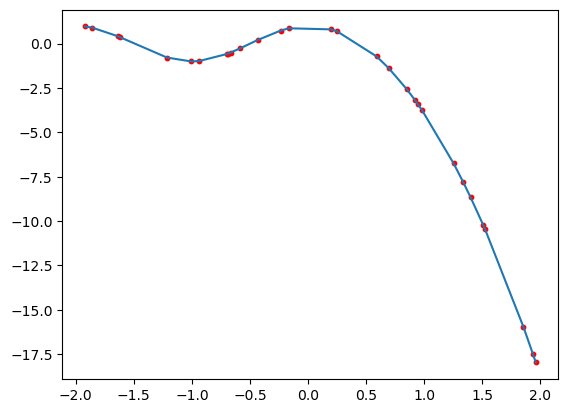

In [6]:
#sort the data by X value
idx=np.argsort(np.sum(X,axis=-1))
X_sorted=X[idx]
Y_sorted=Y[idx]

plt.plot(np.sum(X_sorted,axis=-1),Y_sorted)
plt.scatter(np.sum(X,axis=-1),Y,s=10,c='r')

In [7]:
# Define the models
models = [LinearRegression(), 
          DecisionTreeRegressor(), 
          RandomForestRegressor(), 
          SVR(), 
          KNeighborsRegressor(), 
          GradientBoostingRegressor()
         ]

# Define the model names
model_names = ['Linear Regression', 
               'Decision Tree', 
               'Random Forest', 
               'Support Vector Regression', 
               'KNeighbors Regression', 
               'Gradient Boosting Regression'
              ]
model_number=len(models)

In [8]:
models=list(map(lambda x: x.fit(X,Y),models))
print(list(map(lambda x: x.score(X,Y),models)))

[0.6342118263394486, 1.0, 0.9981497054423479, 0.7147146970116662, 0.9592991054495763, 0.9999995054419785]


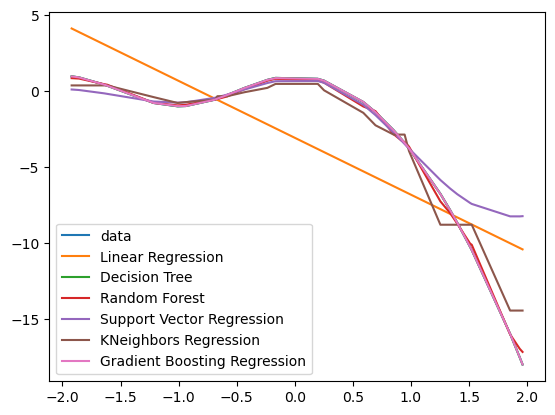

In [9]:
#sort the data by X value
idx=np.argsort(np.sum(X,axis=-1))
X_sorted=X[idx]
Y_sorted=Y[idx]

plt.plot(np.sum(X_sorted,axis=-1),Y_sorted,label='data')
for model,model_name in zip(models,model_names):
    plt.plot(np.sum(X_sorted,axis=-1),model.predict(X_sorted),label=model_name)

plt.legend()

In [523]:
n_additional=10
X_additional,Y_additional=get_data(n_additional,scale,seed=5)
X_test,Y_test=np.concatenate([X_additional,X]),np.concatenate([Y_additional,Y])

In [524]:
model_values=np.stack(list(map(lambda x: x.predict(X_test),models)))
model_values.shape

(6, 40)

In [525]:
eigs,P=np.linalg.eigh(np.cov(model_values-Y_test[None,:]))
eigs

array([8.68451043e-06, 8.35960091e-03, 3.05796856e-01, 4.39161095e-01,
       2.82729537e+00, 1.56055223e+01])

In [526]:
errors=(model_values-Y_test[None,:])**2
errors.shape

(6, 40)

In [527]:
kernel_matrix=np.exp(-(X_test-X_test.T)**2/0.1)
kernel_matrix.shape

(40, 40)

In [528]:
def loss_func(V,errors,kernel_matrix,lam):
    alpha=kernel_matrix@V
    return np.append(alpha*errors-np.log(alpha),lam*np.dot(V,alpha))

def loss_func_exp(V,errors,kernel_matrix,lam):
    alpha=kernel_matrix@V
    return np.append(np.exp(alpha)*errors-alpha,lam*np.dot(V,alpha))


def jac_func(V,errors,kernel_matrix,lam):
    alpha=kernel_matrix@V
    part_1=(errors[:,None]-1/alpha[:,None])*kernel_matrix
    part_2=2*lam*alpha[None,:]
    return np.concatenate([part_1,part_2],axis=0)

def jac_func_exp(V,errors,kernel_matrix,lam):
    alpha=kernel_matrix@V
    part_1=(np.exp(alpha)*errors-1)[:,None]*kernel_matrix
    part_2=2*lam*alpha[None,:]
    return np.concatenate([part_1,part_2],axis=0)

def loss_func_overfit(V,errors,kernel_matrix,lam,train_indices):
    alpha=kernel_matrix@V[:-1]
    overfit=np.ones_like(errors)
    overfit[train_indices]=V[-1]
    train_test_coeff=np.ones_like(errors)/(errors.shape[0]-len(train_indices))
    train_test_coeff[train_indices]=1/len(train_indices)
    return np.append(train_test_coeff*(alpha*errors*overfit-np.log(alpha*overfit)),lam*np.dot(V[:-1],alpha))

def jac_func_overfit(V,errors,kernel_matrix,lam,train_indices):
    alpha=kernel_matrix@V[:-1]
    overfit=np.ones_like(errors)
    overfit[train_indices]=V[-1]
    train_test_coeff=np.ones_like(errors)/(errors.shape[0]-len(train_indices))
    train_test_coeff[train_indices]=1/len(train_indices)
    top_left=(train_test_coeff*(errors*overfit-1/alpha))[:,None]*kernel_matrix
    bottom_left=2*lam*alpha[None,:]
    top_right=np.zeros_like(errors)
    top_right[train_indices]=(train_test_coeff*(alpha*errors-1/overfit))[train_indices]
    bottom_right=np.zeros((1,1))
    return np.block([[top_left,top_right[:,None]],[bottom_left,bottom_right]])
    
lam=0.01
l=[partial(loss_func_exp,errors=error_i+1e-10,kernel_matrix=kernel_matrix,lam=lam) for error_i in errors]
j=[partial(jac_func_exp,errors=error_i+1e-10,kernel_matrix=kernel_matrix,lam=lam) for error_i in errors]
l_overfit=[partial(loss_func_overfit,errors=error_i+1e-10,kernel_matrix=kernel_matrix,lam=lam,train_indices=np.arange(len(X_additional),len(X_test))) for error_i in errors]
j_overfit=[partial(jac_func_overfit,errors=error_i+1e-10,kernel_matrix=kernel_matrix,lam=lam,train_indices=np.arange(len(X_additional),len(X_test))) for error_i in errors]
l_PCA=[partial(loss_func,errors=P[i]@errors+1e-10,kernel_matrix=kernel_matrix,lam=lam) for i in range(P.shape[1])]
j_PCA=[partial(jac_func,errors=P[i]@errors+1e-10,kernel_matrix=kernel_matrix,lam=lam) for i in range(P.shape[1])]

In [529]:
f_prime(np.linspace(-20,20,100))

array([1.01884691e+08, 6.67112612e+07, 4.36638676e+07, 2.85674401e+07,
       1.86826874e+07, 1.22128953e+07, 7.97996644e+06, 5.21168287e+06,
       3.40204567e+06, 2.21961504e+06, 1.44737131e+06, 9.43269299e+05,
       6.14373807e+05, 3.99905913e+05, 2.60133908e+05, 1.69096589e+05,
       1.09838590e+05, 7.12917627e+04, 4.62347568e+04, 2.99585920e+04,
       1.93943232e+04, 1.25430419e+04, 8.10360442e+03, 5.22961802e+03,
       3.37088630e+03, 2.17001607e+03, 1.39503321e+03, 8.95492601e+02,
       5.73908525e+02, 3.67170037e+02, 2.34459849e+02, 1.49406674e+02,
       9.49914535e+01, 6.02437922e+01, 3.81012700e+01, 2.40235791e+01,
       1.50962024e+01, 9.45132215e+00, 5.89410905e+00, 3.66185844e+00,
       2.26897423e+00, 1.40738282e+00, 8.82715006e-01, 5.73570922e-01,
       4.05708708e-01, 3.35938847e-01, 3.42426792e-01, 4.19377120e-01,
       5.74937794e-01, 8.31789619e-01, 1.23039285e+00, 1.83534440e+00,
       2.74584158e+00, 4.11194671e+00, 6.15931901e+00, 9.22648985e+00,
      

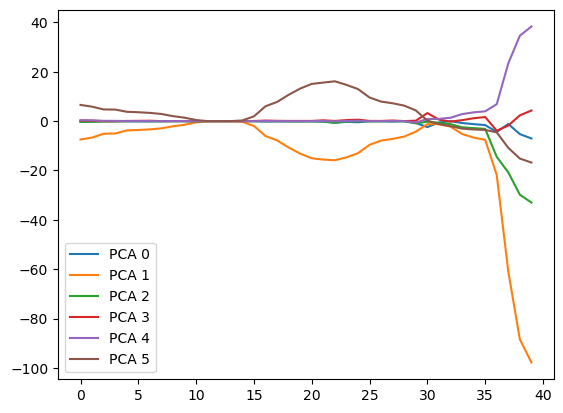

In [530]:
for i in range(P.shape[1]):
    plt.plot((P[i]@errors)[idx],label=f'PCA {i}')
plt.legend()

In [531]:
least_squares_used=partial(least_squares,method='lm')#,ftol=None,xtol=None,gtol=1e-9)

In [532]:
initial_guess=np.linalg.solve(kernel_matrix+lam*np.eye(kernel_matrix.shape[0]),np.log(1/(errors.T+1e-10))).T
initial_guess.shape

(6, 40)

In [533]:
which='basic'
if which=='overfit':
    bound_inf=np.array([0]*X_test.shape[0]+[0])
    bound_sup=np.array([np.inf]*X_test.shape[0]+[np.inf])
    Vs=np.stack([least_squares_used(l_i,np.ones(X_test.shape[0]+1),jac=j_i,bounds=(bound_inf,bound_sup)).x for l_i,j_i in zip(l_overfit,j_overfit)])
    precisions=np.stack([kernel_matrix@V[:-1] for V in Vs])
    overfits=Vs[:,-1]
if which=='basic':
    Vs=[]
    for l_i,j_i,guess in zip(l,j,initial_guess):
        #bounds=(0,np.inf)
        bounds=(-np.inf,np.inf)
        sol=least_squares_used(l_i,guess,jac=j_i,bounds=bounds)
        print(sol)
        Vs.append(sol.x)
    Vs=np.stack(Vs)
    precisions=np.exp(np.stack([kernel_matrix@V for V in initial_guess]))
    overfits=np.ones(Vs.shape[0])
if which=='PCA':
    Vs=np.stack([least_squares_used(l_i,np.ones(X_test.shape[0]),jac=j_i,bounds=(0,np.inf)).x for l_i,j_i in zip(l_PCA,j_PCA)])
    precision_eigenvals=np.stack([kernel_matrix@V for V in Vs])
    precision_matrix=np.einsum('ik,jk,kn->nij',P,P,precision_eigenvals)
    overfits=np.ones(Vs.shape[0])

     message: The maximum number of function evaluations is exceeded.
     success: False
      status: 0
         fun: [ 2.495e+00  1.426e+00 ...  4.571e+00  1.803e+00]
           x: [-1.586e+01 -4.369e+01 ...  2.537e+00 -1.777e+01]
        cost: 181.41579443454822
         jac: [[ 4.543e-01  2.587e-30 ...  4.477e-42  2.836e-39]
               [-5.116e-31 -8.984e-02 ... -9.159e-03 -2.268e-02]
               ...
               [ 4.587e-40  1.855e-02 ...  6.555e-02  7.347e-02]
               [-2.082e-02 -1.032e-02 ... -8.085e-02 -6.996e-02]]
        grad: [ 5.526e-02  1.056e-02 ... -1.053e-02  3.421e-02]
  optimality: 0.07919941033195467
 active_mask: [0 0 ... 0 0]
        nfev: 4000
        njev: 3984
     message: The maximum number of function evaluations is exceeded.
     success: False
      status: 0
         fun: [-1.624e-01  6.440e-01 ...  7.986e-01  1.851e+02]
           x: [ 8.944e+03  1.065e+03 ... -8.191e+03 -5.118e+03]
        cost: 17131.274223119402
         jac: [[-9.701

In [534]:
precisions[1]

array([3.10957520e+05, 4.39427880e+07, 1.85226563e+04, 3.33372831e+01,
       1.88391234e+02, 5.47185289e+02, 2.29015306e+04, 1.15899384e+03,
       8.38788298e+05, 3.81429051e+04, 2.53671375e+10, 2.24545959e+09,
       2.28608015e+11, 1.39774210e+04, 1.21751354e+11, 6.02322039e+07,
       5.11677537e+07, 2.15639354e+08, 2.58869707e+06, 1.56377845e+10,
       2.52299019e+08, 7.92258969e+09, 1.87502210e+10, 1.21108649e+10,
       1.01427500e+07, 5.82191834e+08, 2.02332727e+10, 3.12485512e+07,
       5.07718478e+10, 5.24533662e+05, 3.78541554e+08, 5.30953552e+11,
       1.06369909e+10, 7.77486299e+09, 4.19609073e+08, 1.27035834e+09,
       1.05609530e+07, 4.50982634e+09, 1.92184242e+10, 2.75313910e+08])

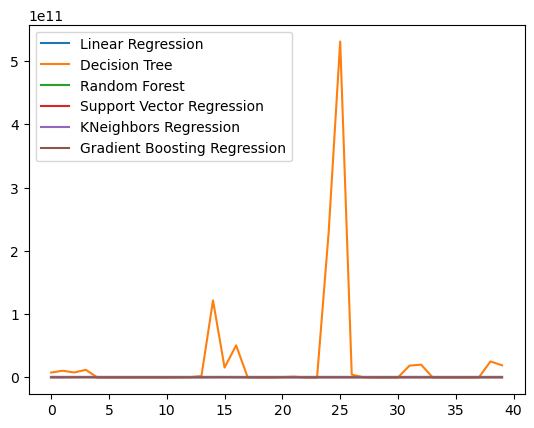

In [535]:
for name,precsion in zip(model_names,precisions):
    plt.plot(precsion[idx],label=name)
plt.legend()

In [536]:
if which=='PCA':
    normalization=np.sum(precision_matrix,axis=(1,2))
    aggregate_coeff=np.sum(precision_matrix,axis=1)/normalization[:,None]
    aggregate_coeff=aggregate_coeff.T
else:
    normalization=np.sum(precisions,axis=0)
    aggregate_coeff=precisions/normalization

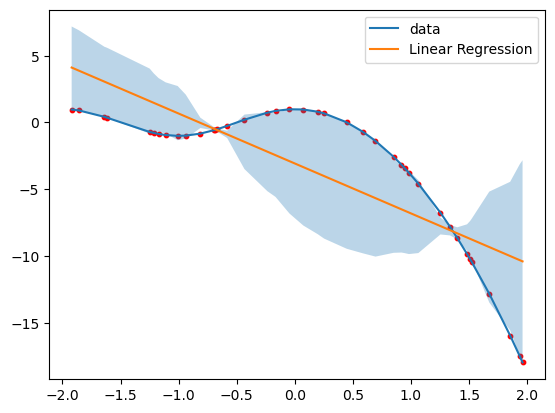

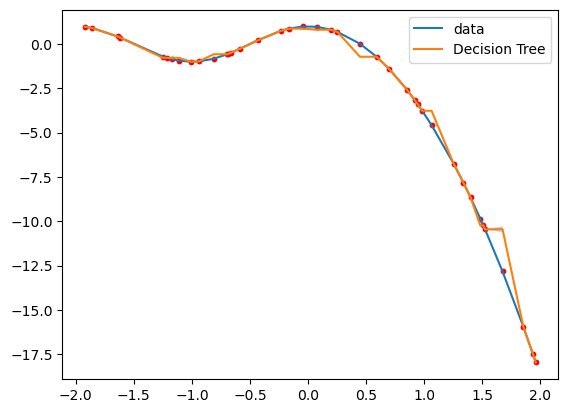

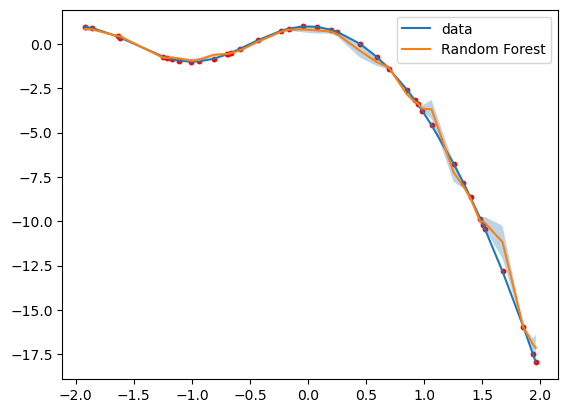

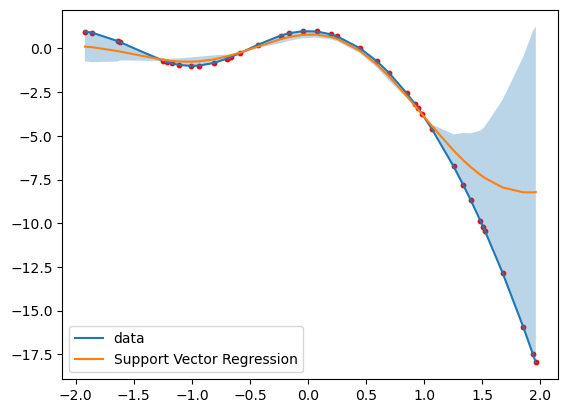

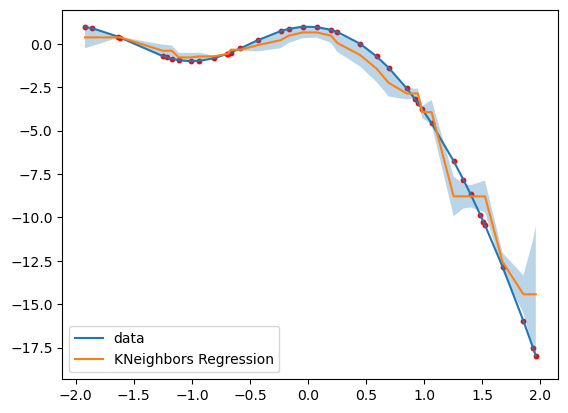

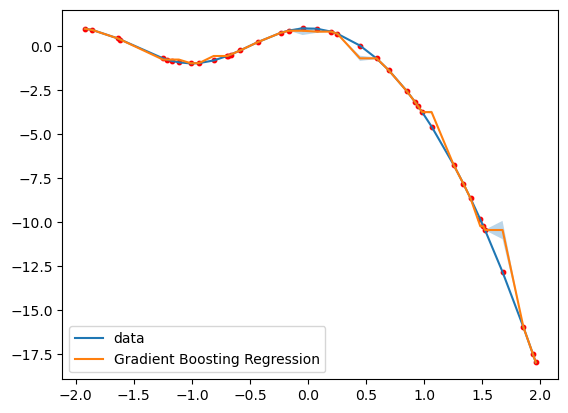

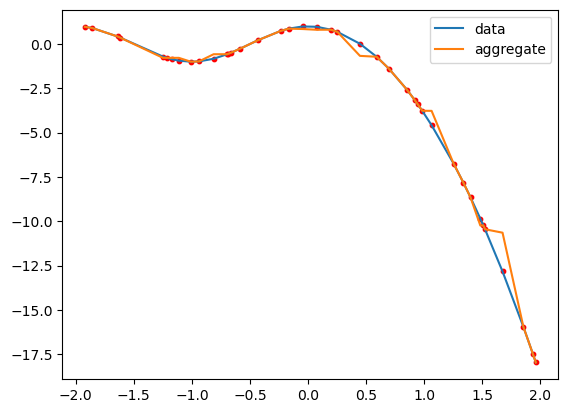

In [537]:
idx=np.argsort(np.sum(X_test,axis=-1))
X_test_sorted=X_test[idx]
Y_test_sorted=Y_test[idx]


for i,model,model_name in zip(range(len(models)),models,model_names):
    plt.figure()
    plt.plot(np.sum(X_test_sorted,axis=-1),Y_test_sorted,label='data')
    plt.plot(np.sum(X_test_sorted,axis=-1),model.predict(X_test_sorted),label=model_name)
    plt.scatter(np.sum(X_test_sorted,axis=-1),Y_test_sorted,s=10,c='r')
    if which=='PCA':
        plt.fill_between(np.sum(X_test_sorted,axis=-1),model.predict(X_test_sorted)-np.sqrt(1/precision_matrix[idx,i,i]),model.predict(X_test_sorted)+np.sqrt(1/precision_matrix[idx,i,i]),alpha=0.3)
    else:
        plt.fill_between(np.sum(X_test_sorted,axis=-1),model.predict(X_test_sorted)-np.sqrt(1/precisions[i,idx]),model.predict(X_test_sorted)+np.sqrt(1/precisions[i,idx]),alpha=0.3)
    plt.legend()
    plt.show()

aggregate=np.einsum('ik,ik->k',aggregate_coeff,model_values)
variance_aggregate=1/normalization**2
plt.figure()
plt.plot(np.sum(X_test_sorted,axis=-1),Y_test_sorted,label='data')
plt.plot(np.sum(X_test_sorted,axis=-1),aggregate[idx],label='aggregate')
plt.scatter(np.sum(X_test_sorted,axis=-1),Y_test_sorted,s=10,c='r')
plt.fill_between(np.sum(X_test_sorted,axis=-1),aggregate[idx]-np.sqrt(variance_aggregate[idx]),aggregate[idx]+np.sqrt(variance_aggregate[idx]),alpha=0.3)
plt.legend()
plt.show()

# New loss

In [538]:
def new_loss_func(V,Y,kernel_matrix,lam):
    alpha=kernel_matrix@V
    return (Y-np.exp(alpha))**2+1/alpha.shape[0]*lam*np.dot(V,alpha)


def new_jac_func(V,Y,kernel_matrix,lam):
    alpha=kernel_matrix@V
    alpha_exp=np.exp(alpha)
    return 2*(kernel_matrix*(alpha_exp*(alpha_exp-Y))[:,None])+2*lam*alpha/alpha.shape[0]


lam=0.01
l=[partial(new_loss_func,Y=error_i+1e-10,kernel_matrix=kernel_matrix,lam=lam) for error_i in errors]
j=[partial(new_jac_func,Y=error_i+1e-10,kernel_matrix=kernel_matrix,lam=lam) for error_i in errors]
least_squares_used=partial(least_squares,method='lm')
initial_guess=[]
for i in range(errors.shape[0]):
    mat=errors[i][:,None]*kernel_matrix*errors[i][None,:]+lam*np.eye(kernel_matrix.shape[0])
    initial_guess.append((errors[i]+1e-10)*np.linalg.solve(mat,(errors[i]+1e-10)*np.log(errors[i]+1e-10)))
initial_guess=np.stack(initial_guess).T
initial_guess.shape

(40, 6)

In [539]:
Vs=[]
for l_i,j_i,guess in zip(l,j,initial_guess.T):
    #bounds=(0,np.inf)
    bounds=(-np.inf,np.inf)
    sol=least_squares_used(l_i,guess,jac=j_i,bounds=bounds)
    print(np.sum(l_i(guess)))
    print(np.sum(l_i(sol.x)))
    print(sol)
    print('-'*10)
    Vs.append(sol.x)
Vs=np.stack(Vs)


2.28755959222247
2.2703239585679005
     message: The maximum number of function evaluations is exceeded.
     success: False
      status: 0
         fun: [ 3.746e-02  4.220e-02 ...  5.531e-02  5.587e-02]
           x: [ 3.945e+01  4.096e+01 ...  3.536e+02  2.047e+02]
        cost: 0.08145443829656326
         jac: [[ 3.631e-01  1.836e-04 ...  2.023e-03  1.782e-03]
               [ 7.129e-04 -2.349e-01 ... -2.194e-02 -5.757e-02]
               ...
               [ 7.129e-04 -1.636e+00 ... -1.605e+01 -1.432e+01]
               [ 7.129e-04 -2.542e+00 ... -8.981e+00 -1.007e+01]]
        grad: [ 9.625e-05  4.067e-03 ...  2.785e-02  2.245e-02]
  optimality: 0.027851581917649693
 active_mask: [0 0 ... 0 0]
        nfev: 4000
        njev: 3887
----------
119.70774215337444
4.80013269217431
     message: The maximum number of function evaluations is exceeded.
     success: False
      status: 0
         fun: [ 1.131e-01  1.200e-01 ...  1.261e-01  1.422e-01]
           x: [ 5.862e+01  5.480e+

In [540]:
#precisions = np.exp(-(kernel_matrix@initial_guess).T)
precisions=np.exp(-np.stack([kernel_matrix@V for V in Vs]))

In [541]:
normalization=np.sum(precisions,axis=0)
aggregate_coeff=precisions/normalization

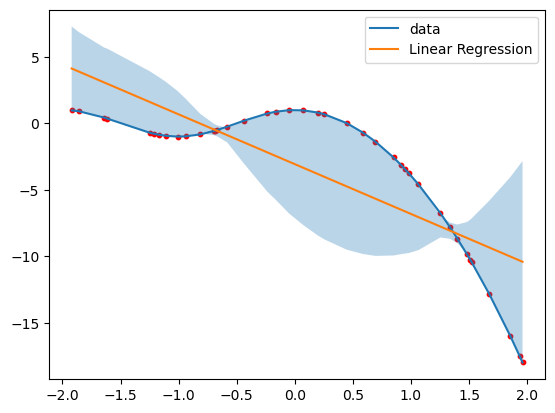

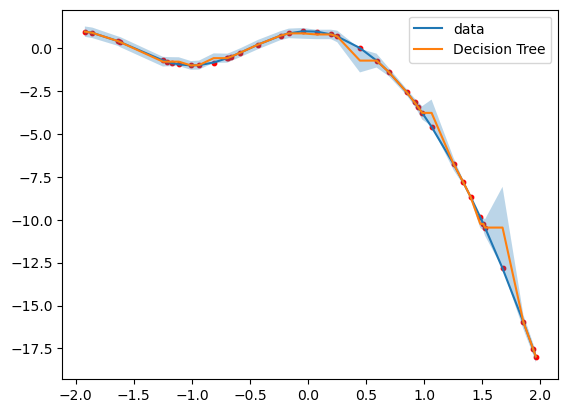

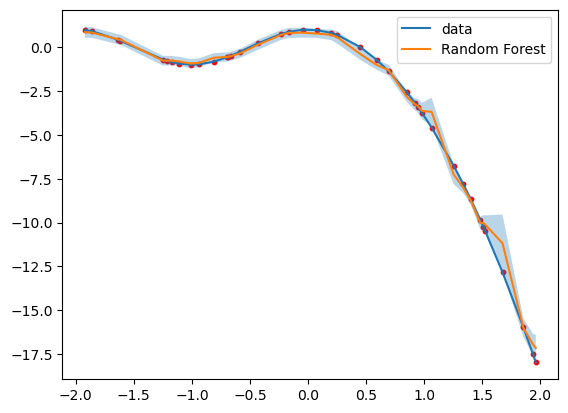

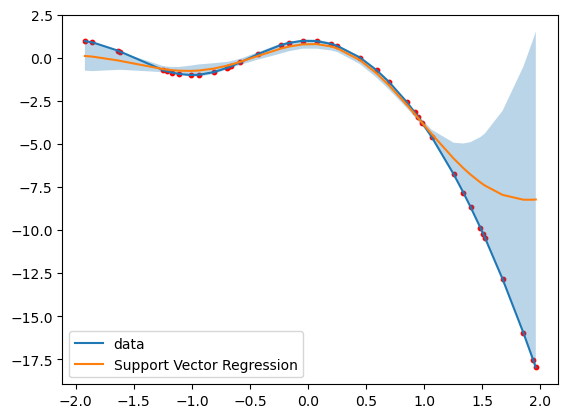

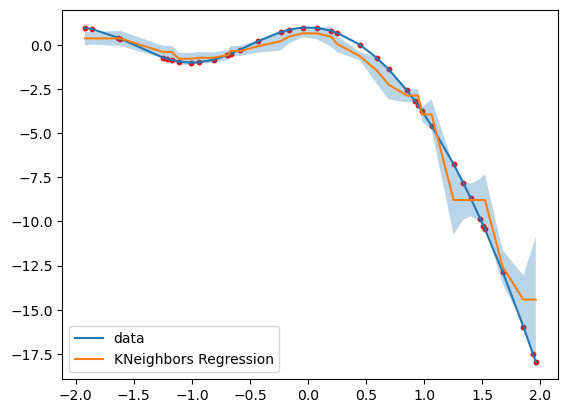

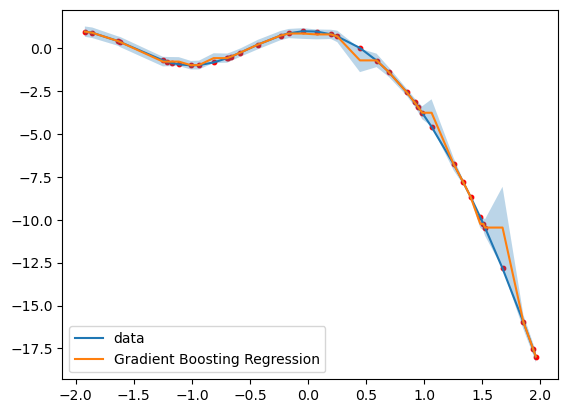

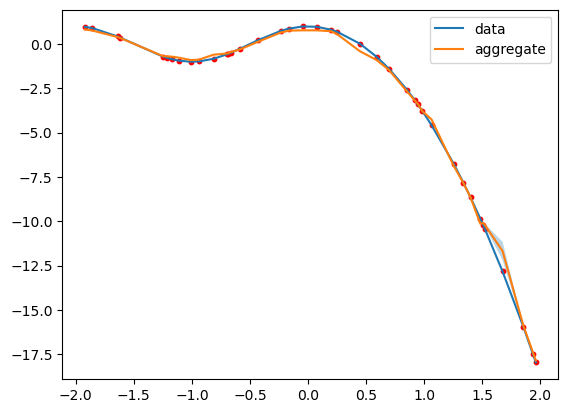

In [542]:
idx=np.argsort(np.sum(X_test,axis=-1))
X_test_sorted=X_test[idx]
Y_test_sorted=Y_test[idx]


for i,model,model_name in zip(range(len(models)),models,model_names):
    plt.figure()
    plt.plot(np.sum(X_test_sorted,axis=-1),Y_test_sorted,label='data')
    plt.plot(np.sum(X_test_sorted,axis=-1),model.predict(X_test_sorted),label=model_name)
    plt.scatter(np.sum(X_test_sorted,axis=-1),Y_test_sorted,s=10,c='r')
    if which=='PCA':
        plt.fill_between(np.sum(X_test_sorted,axis=-1),model.predict(X_test_sorted)-np.sqrt(1/precision_matrix[idx,i,i]),model.predict(X_test_sorted)+np.sqrt(1/precision_matrix[idx,i,i]),alpha=0.3)
    else:
        plt.fill_between(np.sum(X_test_sorted,axis=-1),model.predict(X_test_sorted)-np.sqrt(1/precisions[i,idx]),model.predict(X_test_sorted)+np.sqrt(1/precisions[i,idx]),alpha=0.3)
    plt.legend()
    plt.show()

aggregate=np.einsum('ik,ik->k',aggregate_coeff,model_values)
variance_aggregate=1/normalization**2
plt.figure()
plt.plot(np.sum(X_test_sorted,axis=-1),Y_test_sorted,label='data')
plt.plot(np.sum(X_test_sorted,axis=-1),aggregate[idx],label='aggregate')
plt.scatter(np.sum(X_test_sorted,axis=-1),Y_test_sorted,s=10,c='r')
plt.fill_between(np.sum(X_test_sorted,axis=-1),aggregate[idx]-np.sqrt(variance_aggregate[idx]),aggregate[idx]+np.sqrt(variance_aggregate[idx]),alpha=0.3)
plt.legend()
plt.show()

# Dumb version with overfit



In [543]:


lam=0.01
initial_guess=[]
is_training=np.arange(len(X_additional),len(X_test))
is_training_one_hot=np.zeros(len(X_test))
is_training_one_hot[is_training]=1
overfits=[]
for i in range(errors.shape[0]):
    mat=kernel_matrix+lam*np.eye(kernel_matrix.shape[0])
    inv_training=np.linalg.solve(mat,is_training_one_hot)
    twologci=-np.dot(inv_training,np.log(errors[i]+1e-10))/np.dot(inv_training,is_training_one_hot)

    initial_guess.append(np.linalg.solve(mat,np.log(errors[i]+1e-10)+twologci*is_training_one_hot))
    overfits.append(np.exp(twologci/2))
initial_guess=np.stack(initial_guess).T
initial_guess.shape

(40, 6)

In [544]:
overfits

[1.2138919549063727,
 30098.74256385411,
 3.743654190713239,
 1.2766810268930142,
 1.0255503976301978,
 190.5677511821861]

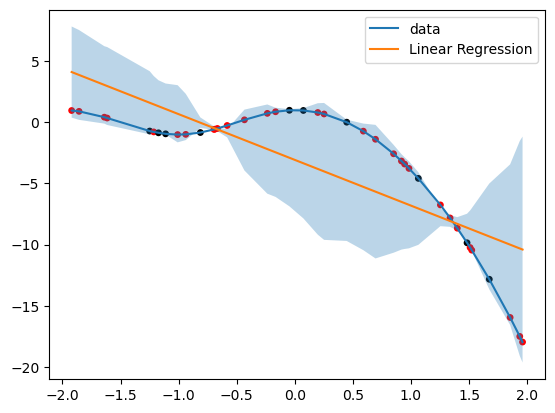

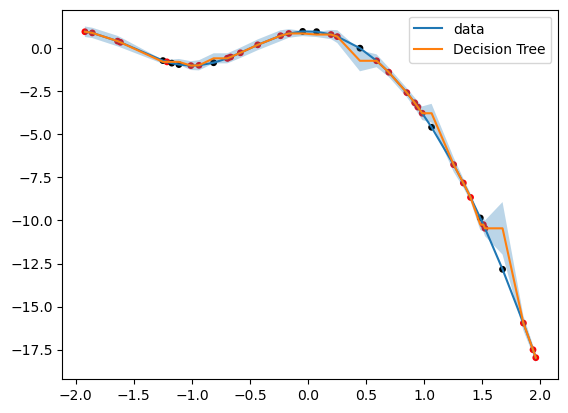

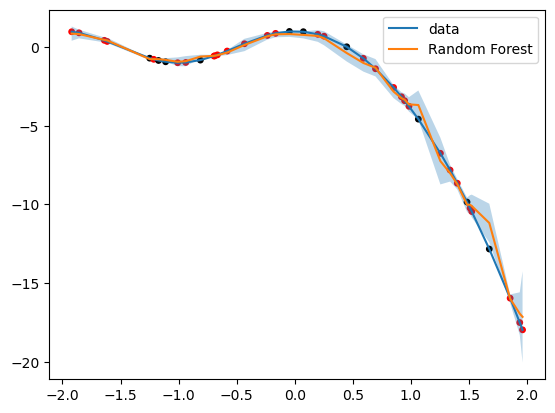

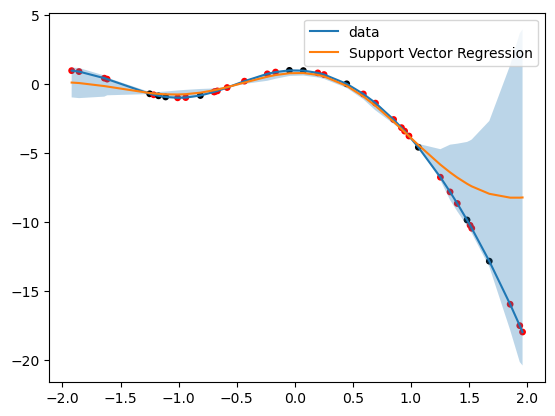

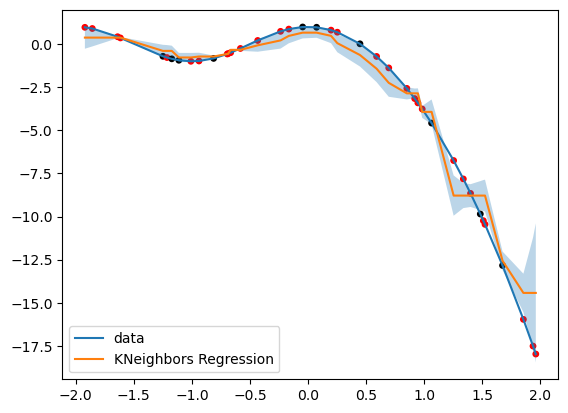

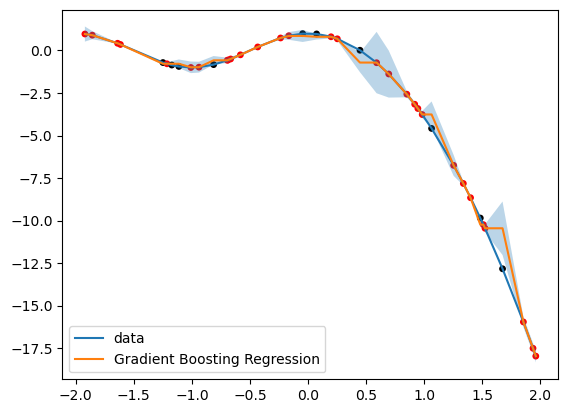

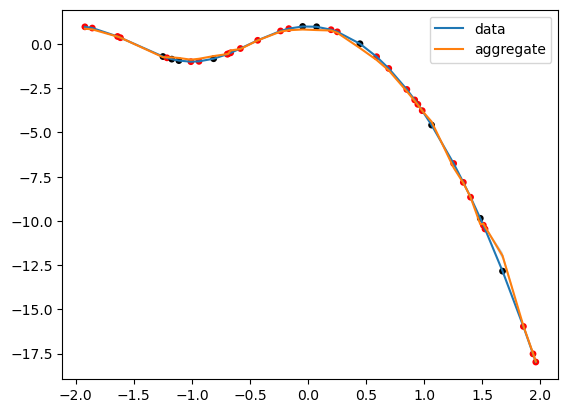

In [545]:
precisions = np.exp(-(kernel_matrix@initial_guess).T)
normalization=np.sum(precisions,axis=0)
aggregate_coeff=precisions/normalization

idx=np.argsort(np.sum(X_test,axis=-1))
X_test_sorted=X_test[idx]
Y_test_sorted=Y_test[idx]
is_training=np.arange(len(X_additional),len(X_test))
colors=np.array(['r' if i in is_training else 'k' for i in range(len(X_test))])



for i,model,model_name in zip(range(len(models)),models,model_names):
    plt.figure()
    plt.plot(np.sum(X_test_sorted,axis=-1),Y_test_sorted,label='data')
    plt.plot(np.sum(X_test_sorted,axis=-1),model.predict(X_test_sorted),label=model_name)
    plt.scatter(np.sum(X_test_sorted,axis=-1),Y_test_sorted,s=15,c=colors[idx])
    if which=='PCA':
        plt.fill_between(np.sum(X_test_sorted,axis=-1),model.predict(X_test_sorted)-np.sqrt(1/precision_matrix[idx,i,i]),model.predict(X_test_sorted)+np.sqrt(1/precision_matrix[idx,i,i]),alpha=0.3)
    else:
        plt.fill_between(np.sum(X_test_sorted,axis=-1),model.predict(X_test_sorted)-np.sqrt(1/precisions[i,idx]),model.predict(X_test_sorted)+np.sqrt(1/precisions[i,idx]),alpha=0.3)
    plt.legend()
    plt.show()

aggregate=np.einsum('ik,ik->k',aggregate_coeff,model_values)
variance_aggregate=1/normalization**2
plt.figure()
plt.plot(np.sum(X_test_sorted,axis=-1),Y_test_sorted,label='data')
plt.plot(np.sum(X_test_sorted,axis=-1),aggregate[idx],label='aggregate')
plt.scatter(np.sum(X_test_sorted,axis=-1),Y_test_sorted,s=15,c=colors[idx])
plt.fill_between(np.sum(X_test_sorted,axis=-1),aggregate[idx]-np.sqrt(variance_aggregate[idx]),aggregate[idx]+np.sqrt(variance_aggregate[idx]),alpha=0.3)
plt.legend()
plt.show()